In [138]:
# util imports
import os
import random
import numpy as np

# pytorch imports
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [139]:
# set seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

# define device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# path to train data
train_path = os.path.join('unzipped_folder', 'train', 'train')
print(train_path)

unzipped_folder/train/train


In [140]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your ZIP file in Google Drive
zip_path = os.path.join("drive", "My Drive", "CSE-144-Final-Dataset", "ucsc-cse-144-winter-2025-final-project.zip")

# Extract the ZIP file
extract_path = "/content/unzipped_folder"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"ZIP file extracted to: {extract_path}")

# List extracted files
print(os.listdir(extract_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ZIP file extracted to: /content/unzipped_folder
['train', 'test', 'sample_submission.csv']


In [141]:
# composite the transforms
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),

#     # this should theoretically be wtvr the pretrained model was trained on
#     transforms.Normalize(mean=(0.48, 0.48, 0.48), std=(0.0039, 0.0039, 0.0039))
# ])
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),  # Perspective transform
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48, 0.48, 0.48), std=(0.229, 0.224, 0.225)),
])


trainset = datasets.ImageFolder(root=train_path, transform=transform)

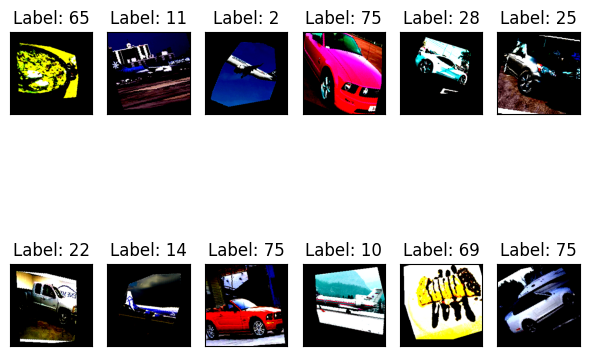

In [142]:
# For matrix operations
import numpy as np

# Data visualizaton.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn

fig, ax = plt.subplots(2, 6)
fig.set_size_inches(6, 6)

for i in range(2):
    for j in range(6):
        l=rn.randint(0, len(trainset))
        ax[i, j].imshow(np.transpose(trainset[l][0].numpy(), (1, 2, 0)), cmap='gray')
        ax[i, j].set_title('Label: ' + str(trainset[l][1]))
        # Hide grid lines
        ax[i, j].grid(False)
        # Hide axes ticks
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.tight_layout()

In [143]:
# put the trainset into a dataloader
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

class ViT_B16_Head(nn.Module):
    def __init__(self, num_classes=100):
        super(ViT_B16_Head, self).__init__()
        self.base_model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        for param in self.base_model.parameters():
            param.requires_grad = False

        # unfreeze last 2 attention layers
        for name, param in self.base_model.named_parameters():
            if "encoder.layers.10" in name or "encoder.layers.11" in name:
                param.requires_grad = True

        self.base_model.heads = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features=768, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=512, out_features=num_classes)  # num_classes=100
        )

    def forward(self, x):
        return self.base_model(x)

model = ViT_B16_Head()
print(model)


ViT_B16_Head(
  (base_model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1

In [144]:
base_model = ViT_B16_Head().to(device)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

loss_fn = nn.CrossEntropyLoss()

# Training the network
num_epochs = 20

In [145]:
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            predicted = outputs.data.argmax(dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total if total > 0 else 0

In [146]:
# save loss and accuracies
train_losses = []
train_acc = []

In [147]:
images, target = next(iter(train_loader))
images.size()

torch.Size([128, 3, 224, 224])

In [ ]:
for epoch in range(num_epochs):
    base_model.train()
    running_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)

        # forward pass
        preds = base_model(images)

        # Calculate the loss
        loss = loss_fn(preds, targets)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # calculate running loss
        loss_value = loss.item()
        running_loss += loss_value

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = calculate_accuracy(train_loader, base_model)
    train_acc.append(train_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.7f}, Train Acc: {train_accuracy:.7f}%')


In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
# plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
# plt.plot(test_acc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

In [ ]:
def save_model(model, folder="models", base_filename="model.pth"):
    os.makedirs(folder, exist_ok=True)  # Create folder if it doesn't exist
    filepath = os.path.join(folder, base_filename)

    # Check if file exists and iterate
    if os.path.exists(filepath):
        i = 1
        filename, ext = os.path.splitext(base_filename)
        while os.path.exists(os.path.join(folder, f"{filename}_{i}{ext}")):
            i += 1
        filepath = os.path.join(folder, f"{filename}_{i}{ext}")

    torch.save(model.state_dict(), filepath)
    print(f"Model saved at: {filepath}")
    return filepath

save_model(net)

In [ ]:
from PIL import Image
import pandas as pd

In [ ]:
def testset_predictions(model, base_model, root_dir, transform):

    model.eval()
    base_model.eval()

    preds = []

    # Get length of testset
    num_images = len(os.listdir(root_dir))

    for idx in range(num_images):
        # get the image path
        img_path = os.path.join(root_dir, f'{idx}.jpg')

        # open the image with the pillow library
        image = Image.open(img_path)

        # Transform if necessary
        if transform:
            image = transform(image)

        # add a dimension for batch
        image = torch.unsqueeze(image, 0)

        # print(image.size())

        with torch.no_grad():
            base_model_features = base_model.features(image.to(device))

        # print(base_model_features.size())

        output = model(base_model_features)

        _, predicted_idx = torch.max(output.cpu().data, 1)

        preds.append([f'{idx}.jpg', predicted_idx.item()])

    # Once all predictions are collected, create the DataFrame
    df_preds = pd.DataFrame(preds, columns=['ID', 'Predicted_Label'])

    return df_preds

In [ ]:
test_path = os.path.join("unzipped_folder", "test", "test")

# composite the transforms
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),

    # this should theoretically be wtvr the pretrained model was trained on
    transforms.Normalize(mean=(0.48, 0.48, 0.48), std=(0.0039, 0.0039, 0.0039))
])

df_preds = testset_predictions(net, base_model, test_path, test_transform)

In [ ]:
df_preds

In [ ]:
df_preds.to_csv('test_submission.csv', index=False)